In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from matplotlib.markers import MarkerStyle
import pandas as pd
perp=35
figsizes=(20,20)

## t-distribution Stochastic Neighbor Embedding (t-SNE)

t-SNE is an algorithm for visualizing high-dimensional data by projecting it into a low-dimensional space. t-SNE is the current state of the art for dimensionality reduction algorithms.

Here's how t-SNE works:

### - t-SNE Step by Step

**Similarity Matrix**

By using a **Gaussian distribution**, t-SNE starts by converting the high-dimensional Euclidean distances between datapoints into conditional probabilities that represent **similarities**.

The similarity of datapoint $x_j$ to datapoint $x_i$ is 

$$
p_{j|i} = C \exp\left(-\|x_i - x_j\|_2^2/2\sigma^2_i\right), \qquad \mbox{where} \qquad C = \frac{1}{\sum_{k\neq i} \exp\left(-\|x_i - x_k\|_2^2/2\sigma^2_i\right)}.
$$

The constant $C$ is just a normalization constant (to make the probabilities add up to one).
For nearby datapoints, $p_{j|i}$ is relatively high, whereas for widely separated datapoints, $p_{j|i}$ will be almost infinitesimal.
The similarity $p_{i|i}$ is defined to be zero.

**Perplexity**

The parameter $σ_i$ is the variance of the Gaussian that is centered on datapoint $x_i$.
For each datapoint $x_i$, the algorithm has to select $\sigma_i$.
The method that t-SNE uses for determining the value of $\sigma_i$ is based on **perplexity**.

The perplexity is defined as

$$
\mathrm{perplexity} = \exp\left(\sum_j -p_{j|i}\log (p_{j|i}) \right).
$$

Roughly speaking, the perplexity can be interpreted as a measure of the effective number of neighbors of datapoint $x_i$ (i.e., points that are within a distance $2\sigma_i$ from $x_i$). 
t-SNE selects the value of $\sigma_i$ that produces a fixed perplexity that is specified by the user.

Text(0.5, 1.0, 'Number of neighbors = 20')

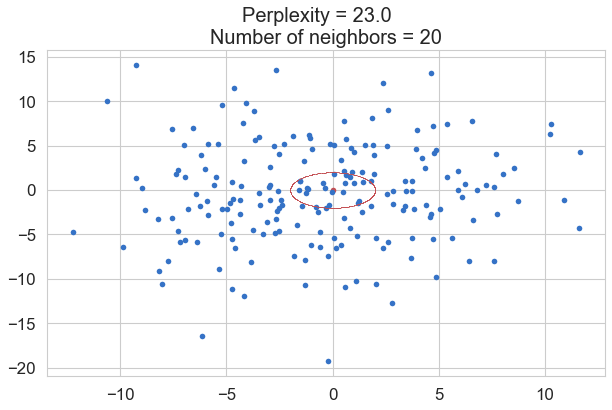

In [2]:
'perplexity example'
sigma = 1

# xi point
xi = np.array([0,0]) 
# xj points
m = 200
xj = 5*np.random.randn(m,2)

# compute distances from xj points to xi
distances = np.array([np.linalg.norm(xi-xj[j]) for j in range(m)])
# compute similarities between xj points and xi
p = np.exp(-np.square(distances)/(2*(sigma**2)))
p = p/np.sum(p)
# compute perplexity
perplexity = np.exp(np.sum(-p*np.log(p)))

# compute number of neighbors of xi (i.e., points that are within a 2*sigma distance from xi)
n_neighbors = np.sum(distances<2*sigma) 

# plot points
plt.figure(figsize=(10,6))
plt.plot(xi[0],xi[1],'ro')
plt.plot(xj[:,0],xj[:,1],'bo')

# plot a circle centered at xi with radius 2*sigma
angles = 2*np.pi*np.random.randn(2000)
xc = 2*sigma*np.sin(angles)
yc = 2*sigma*np.cos(angles)
plt.plot(xc,yc,'ro',markersize=0.5,)
plt.suptitle('Perplexity = '+str(np.round(perplexity)),fontsize=20)
plt.title('Number of neighbors = '+str(n_neighbors),fontsize=20)

In [3]:
def compute_perplexity(D, beta=1.0):
    """
        Given the distances D, it computes the logarithm of 
        the perplexity, and the P-column (similarities) for a specific value of 
        beta = 1/2*sigma**2
    """

    # Compute P-column and corresponding log-perplexity
    P_column = np.exp(-D * beta)
    sumP = np.sum(P_column)
    log_perplexity = np.log(sumP) + beta * np.sum(D * P_column) / sumP
    P_column = P_column / sumP
    return log_perplexity, P_column

**Choosing the Sigmas: Binary Search**

The perplexity is an increasing function of $\sigma_i$ (i.e., the perplexity increases as $\sigma_i$ increases). 
t-SNE performs a **binary search** for the value of $\sigma_i$ that produces $p_{j|i}$ values with a **fixed perplexity that is specified by the user**.
The basic reason is that in t-SNE, we want the number of neighbors to be roughly the same for all points to prevent any single point from wielding a disproportionate influence. This means that we want $\sigma_i$  to be small for points in densely populated areas and large for sparse areas

**Remark**: binary search (aka bisection method) works by repeatedly dividing in half the interval that could contain the desired value of $\sigma_i$.

In [4]:
def binary_search(D, tol, perplexity):
    '''
    Given the distances D, it performs a binary search
    to find the value of beta = 1/2*sigma**2 that produces the specified perplexity
    '''
    
    beta = 1.0 # initial beta
    logU = np.log(perplexity) # log of the specified perplexity
    
    # interval range
    betamin = -np.inf
    betamax = np.inf
    
    thisPerplexity, thisP_column = compute_perplexity(D,beta)
    
    # Evaluate whether the perplexity is within tolerance
    Perplexity_diff = thisPerplexity - logU
    tries = 0
    while np.abs(Perplexity_diff) > tol and tries < 50: 
        if Perplexity_diff > 0: # decrease beta (i.e., increase sigma)
            betamin = beta
            if betamax == np.inf:
                beta = beta * 2.
            else:
                beta = (beta + betamax) / 2.
        else: # increase beta (i.e., decrease sigma)
            betamax = beta
            if betamin ==  -np.inf:
                beta = beta / 2.
            else:
                beta = (beta + betamin) / 2.

        # Recompute the values
        thisPerplexity, thisP_column = compute_perplexity(D,beta)
        Perplexity_diff = thisPerplexity - logU
        tries += 1
    return beta, thisPerplexity, thisP_column

Text(0.5, 1.0, 'Number of neighbors = 50')

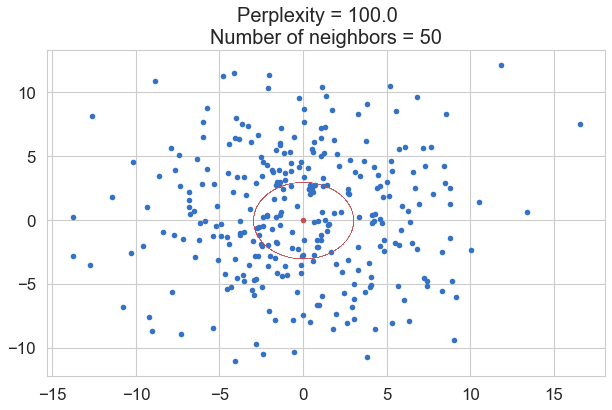

In [5]:
'test the binary_search function'
# xi point 
xi = np.array([0,0]) 
# xj points
m = 300
xj = 5*np.random.randn(m,2)

# compute distances from xj points to xi
distances = np.array([np.linalg.norm(xi-xj[j]) for j in range(m)])

# desired perplexity
desired_perplexity = 100

# find the value of sigma that produces the specified perplexity
beta, thisPerplexity, thisP_column = binary_search(D = distances,
                     tol = 1e-5, 
                     perplexity = desired_perplexity)
sigma = np.square(1/(beta)) # compute sigma from beta
# check that the perplexity is equal to the specified perplexity
perplexity = np.exp(thisPerplexity) # our function computes the log of the perplexity

# compute number of neighbors
n_neighbors = np.sum(distances<2*sigma) 

# plot points
plt.figure(figsize=(10,6))
plt.plot(xi[0],xi[1],'ro')
plt.plot(xj[:,0],xj[:,1],'bo')

# plot a circle centered at xi with radius 2*sigma
angles = 2*np.pi*np.random.randn(2000)
xc = 2*sigma*np.sin(angles)
yc = 2*sigma*np.cos(angles)
plt.plot(xc,yc,'ro',markersize=0.5,)
plt.suptitle('Perplexity = '+str(np.round(perplexity)),fontsize=20)
plt.title('Number of neighbors = '+str(n_neighbors),fontsize=20)

Text(0.5, 1.0, 'Number of neighbors = 2')

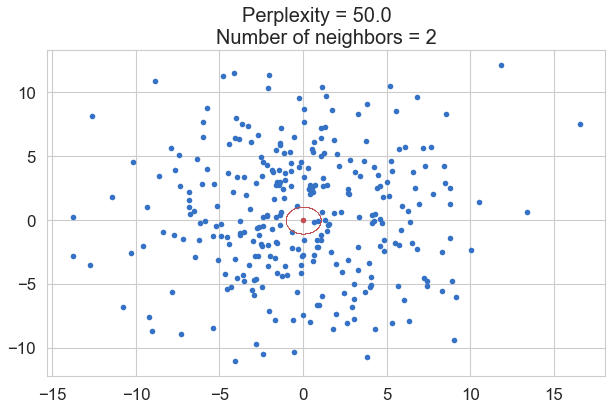

In [6]:
'test the binary_search function'
# compute distances from xj points to xi
distances = np.array([np.linalg.norm(xi-xj[j]) for j in range(m)])

# desired perplexity
desired_perplexity = 50

# find the value of sigma that produces the specified perplexity
beta, thisPerplexity, thisP_column = binary_search(D = distances,
                     tol = 1e-5, 
                     perplexity = desired_perplexity)
sigma = np.square(1/(beta)) # compute sigma from beta
# check that the perplexity is equal to the specified perplexity
perplexity = np.exp(thisPerplexity) # our function computes the log of the perplexity

# compute number of neighbors
n_neighbors = np.sum(distances<2*sigma) 

# plot points
plt.figure(figsize=(10,6))
plt.plot(xi[0],xi[1],'ro')
plt.plot(xj[:,0],xj[:,1],'bo')

# plot a circle centered at xi with radius 2*sigma
angles = 2*np.pi*np.random.randn(2000)
xc = 2*sigma*np.sin(angles)
yc = 2*sigma*np.cos(angles)
plt.plot(xc,yc,'ro',markersize=0.5,)
plt.suptitle('Perplexity = '+str(np.round(perplexity)),fontsize=20)
plt.title('Number of neighbors = '+str(n_neighbors),fontsize=20)

**Recreating the Original Similarities**

Next, t-SNE converts the high-dimensional dataset $X = \{x_1,x_2,\ldots,x_m\}$ into two or three-dimensional data $Y=\{y_1,y_2,\ldots,y_m\}$ that can be displayed in a scatterplot.
t-SNE uses the **Student t-distribution** to recreate the similarities $p_{j|i}$ in low-dimensional space.

 The similarity of datapoint $y_j$ to datapoint $y_i$ in the corresponding low-dimensional space is
 
 $$
 q_{j|i} = C (1+\|y_i-y_j\|_2^2)^{-1} \qquad \mbox{where} \qquad C = \sum_{k}\sum_{\ell\neq k}(1+\|y_k-y_\ell\|_2^2)^{-1},
 $$
 and where we set $q_{i|i}=0$.

**Remark**: The natural choice of using a Gaussian distribution

$$
q_{j|i} = C \exp\left(-\|y_i - y_j\|_2^2/2\right)
$$

does not work well in practice. 
All the points get "squashed" in the lower dimension.
This was known as the crowding problem.
The Student t distribution prevents crowding.

 The Student t-distribution is very much like the Gaussian, except that it has heavy tails, meaning that outliers have a much higher probability of occurrence, as shown in the graph below.

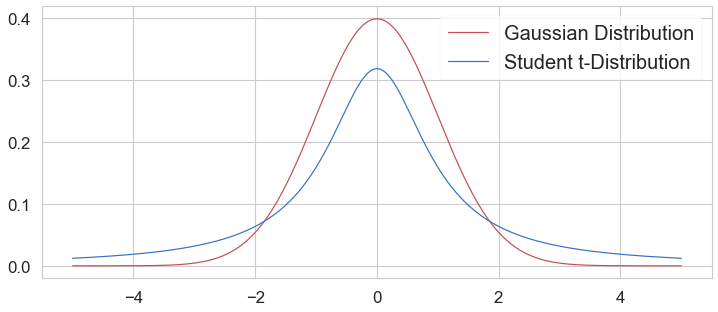

In [7]:
'Gaussian vs Student'
xplot = np.linspace(-5,5,1000)
# Guassian Distribution
yG = np.exp(-(xplot**2)/2)/np.sqrt(2*np.pi)
# Student t Distribution
yS = 1/(1+(xplot**2))/np.pi

# Plot the two distributions
plt.figure(figsize=(12,5))
plt.plot(xplot,yG,'r-', label = 'Gaussian Distribution')
plt.plot(xplot,yS,'b-', label = 'Student t-Distribution')
plt.legend(fontsize=20)

**Cost Function**

 t-SNE then tries to minimize the difference between the similarities $p_{j|i}$ and $q_{j|i}$ in higher-dimensional and lower-dimensional space. 
 To do this, t-SNE minimizes the cost function
 
 $$
 \mathrm{cost} = \sum_{i=1}^m\sum_{j=1}^m p_{ij}\log\frac{p_{ij}}{q_{ij}} \qquad \mbox{where} \qquad p_{ij} = \frac{p_{j|i}+p_{i|j}}{2m} \qquad \mbox{and} \qquad q_{ij} =  q_{j|i} 
 $$

Two comments on the cost function:
1. the cost function is equal to zero only when  $p_{ij}=q_{ij}$, for $i,j=1,2,\ldots,m$.
2. Stochastic Neighbor Embedding (SNE), the ancestor of t-SNE, minimizes the cost function

 $$
 \mathrm{cost} = \sum_{i=1}^m\sum_{j=1}^m p_{j|i}\log\frac{p_{j|i}}{q_{j|i}}
 $$
 
 This cost function seems more natural, but it does not work well when the dataset contains outliers.
 This is why $p_{j|i}$ was replaced with $p_{ij}=\frac{p_{j|i}+p_{i|j}}{2m}$ in the cost function.

**The Gradient**

The gradient of the cost function is surprisingly simple

$$
\frac{\partial}{\partial y_i} \mathrm{cost} = 4 \sum_{j=1}^m (p_{ij}- q_{ji})(y_i-y_j)(1+\|y_i-y_j\|_2^2)^{-1}
$$

**Minimizing the Cost Function**

The minimization method is mostly just simple **gradient descent with momentum**. There are, however, several tricks that make the convergence faster.

**Trick 1 - PCA:** t-SNE is faster if we start by using PCA to reduce the dimensionality of the dataset. 

**Trick 2 - Early exaggeration:** Early exaggeration is a trick where all the $p_{ij}$ are multiplied and "exaggerated" at the early stages of optimization. The effect of this is to force the values of $q_{ij}$  to become more focused on larger $ p_{ij} $ (i.e. closer points), making early clusters more tightly knit, allowing them to "move around" more easily without getting in each others' ways.

**Trick 3 - Changing the learning rate:** If the gradient at iteration $i$ and the gradient descent update at iteration $i-1$ have different signs (positive-negative or negative-positive), it indicates that GD is probably going in the right direction (towards a minimum). In this case, we slightly increase the learning rate. 
Otherwise, we slightly decrease it.

### 11.4.2 t-SNE implementation

In [8]:
def tsne(X, no_dims=2, initial_dims=50, perplexity=30.0, eta=500, max_iter = 1000):
    """
        Runs t-SNE on the dataset to reduce its
        dimensionality to no_dims dimensions. 
        
    Parameters:
    ----------
    
    no_dims (default=2): Dimension of the embedded space
    
    initial_dims (default=50): dimension of the initial PCA dimensionality reduction
    
    perplexity (default=30): The perplexity is related to the number of nearest neighbors. 
                             Consider selecting a value between 5 and 50.
    
    eta (default=500): learning rate
    
    max_iter (default=1000): Gradient Descent iteration
    """
    
    # useful functions 
    from scipy.spatial import distance
    from numpy.linalg import eig
    def pca(X, initial_dims=initial_dims):
        """
            Runs PCA on the mxn array X in order to reduce its dimensionality to
            initial_dims dimensions.
        """
        print("Preprocessing the data using PCA...")
        m, n = X.shape
        X = X - np.mean(X,axis=0) # center X
        _,_,v = np.linalg.svd(X,full_matrices=False)
        Y = X@v[:initial_dims].T
        return Y
    def compute_perplexity(D, beta=1):
        """
            Compute the log-perplexity and the P-column for a specific value of the
            beta = 1/2*sigma**2
        """
        # Compute P-column and corresponding perplexity
        P = np.exp(-D*beta)
        sumP = np.sum(P)
        perplexity = np.log(sumP) + beta*np.sum(D*P)/sumP
        P = P/sumP
        return perplexity, P
    def x2p(X, tol=1e-5, perplexity=30.0):
        """
            Performs a binary search to get P-values in such a way that each
            conditional Gaussian has the same perplexity.
        """
        m,n = X.shape
        # compute all pairwise distances
        D = np.square(distance.squareform(distance.pdist(X)))
        # initialize variables
        P = np.zeros((m, m))
        beta = np.ones((m, 1))
        logU = np.log(perplexity)
        # Compute P matrix
        for i in range(m):
            # interval range
            betamin = -np.inf
            betamax = np.inf
            # Print progress
            if i % 500 == 0:
                print("Computing P-values for point %d of %d..." % (i, m))
                
            # Compute the similarities and perplexity
            idx = np.concatenate((range(0,i),range(i+1,m))).astype('int')
            Di = D[idx,i] 
            Perplexity,P_column = compute_perplexity(Di, beta[i])
            
            # Perform a binary search
            PerplexityDiff = Perplexity - logU
            tries = 0
            while np.abs(PerplexityDiff) > tol and tries < 50:
                if PerplexityDiff > 0:
                    betamin = beta[i].copy()
                    if betamax == np.inf: 
                        beta[i] = beta[i] * 2.
                    else:
                        beta[i] = (beta[i] + betamax) / 2.
                else:
                    betamax = beta[i].copy()
                    if betamin == -np.inf: 
                        beta[i] = beta[i] / 2.
                    else:
                        beta[i] = (beta[i] + betamin) / 2.               
                # Recompute perplexiy
                Perplexity, P_column = compute_perplexity(Di, beta[i])
                PerplexityDiff = Perplexity - logU
                tries += 1
            # Set the final column of P
            P[idx,i] = P_column
        # Return final P-matrix
        print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
        return P
    
    #################### MAIN FUNCTION ##################
    m,n = X.shape
    # Perform PCA
    X = pca(X, initial_dims)
    # Gradient Descent with Momentum parameters
    initial_momentum = 0.5
    final_momentum = 0.8
    min_gain = 0.01 
    # Initialize variables
    Y = np.random.randn(m, no_dims)
    dY = np.zeros((m, no_dims)) # gradient
    iY = np.zeros((m, no_dims)) # gradient on previous iteration
    gains = np.ones((m, no_dims)) 
    
    # Compute P matrix
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4
    P = np.maximum(P, 1e-12)
    
    # Gradient Descent
    for iter in range(max_iter):
        # Compute pairwise affinities qij
        DY = np.square(distance.squareform(distance.pdist(Y)))
        num = 1/(1+DY)
        np.fill_diagonal(num, 0) #set diagonal entries of num to 0
        Q = num/np.sum(num) # normalize 
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PminusQ = P - Q     
        for i in range(m):
            dY[i] = 4*(PminusQ[:, i] * num[:, i])@(Y[i]-Y)
        
        # Momentum coefficient
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        # Increase or decrease learning rate    
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain 
        
        # Update
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.mean(Y,axis=0) # center the dataset


        # Compute current value of cost function
        if (iter + 1) % 100 == 0:
            cost = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, cost))
        # Stop early exaggeration    
        if iter == 100: 
            P = P / 4.
    # Return solution 
    return Y

## Lets use this method on Mineral data from the USGS

In [9]:
import pandas as pd

In [10]:
data=pd.read_csv('interp_smoothed_usgs_reflectance.csv',index_col=0)
data.head(2)        

Minerals       443       444       445       446       447       448  \
0      Acmite  0.034215  0.041745  0.049730  0.058172  0.067049  0.076341   
1  Actinolite  0.032977  0.041117  0.049783  0.058974  0.068667  0.078838   

        449       450       451  ...      2194      2195      2196      2197  \
0  0.086027  0.096089  0.106509  ...  0.000681  0.000608  0.000536  0.000463   
1  0.089463  0.100520  0.111986  ...  0.000825  0.000737  0.000649  0.000561   

       2198      2199      2200      2201      2202      2203  
0  0.000390  0.000318  0.000245  0.000172  0.000100  0.000027  
1  0.000473  0.000385  0.000297  0.000209  0.000121  0.000033  

[2 rows x 1763 columns]

To better undstand the groups of minerals it is nessecary to process the mineral names so they are grouped by thier base mineral

In [11]:
data_small=data.drop('Minerals',axis=1)
data_small

443       444       445       446       447       448       449  \
0     0.034215  0.041745  0.049730  0.058172  0.067049  0.076341  0.086027   
1     0.032977  0.041117  0.049783  0.058974  0.068667  0.078838  0.089463   
2     0.026365  0.035249  0.044702  0.054727  0.065296  0.076383  0.087962   
3     0.023850  0.033116  0.042955  0.053368  0.064329  0.075810  0.087787   
4     0.022148  0.031759  0.041944  0.052704  0.064011  0.075839  0.088161   
...        ...       ...       ...       ...       ...       ...       ...   
1868  0.696847  0.702731  0.708189  0.713219  0.717853  0.722121  0.726053   
1869  0.001025  0.008160  0.015946  0.024387  0.033447  0.043092  0.053290   
1870  0.045459  0.049190  0.053225  0.057575  0.062239  0.067216  0.072510   
1871  0.485001  0.491590  0.497753  0.503491  0.508855  0.513898  0.518665   
1872  0.577516  0.583974  0.589939  0.595412  0.600442  0.605079  0.609369   

           450       451       452  ...      2194      2195      2196  \
0     0.096089  0.106509  0.117267  ...  0.000681  0.000608  0.000536   
1     0.100520  0.111986  0.123843  ...  0.000825  0.000737  0.000649   
2     0.100009  0.112500  0.125413  ...  0.001187  0.001061  0.000934   
3     0.100233  0.113126  0.126441  ...  0.001983  0.001771  0.001560   
4     0.100953  0.114189  0.127848  ...  0.002251  0.002011  0.001771   
...        ...       ...       ...  ...       ...       ...       ...   
1868  0.729677  0.733017  0.736100  ...  0.766125  0.766854  0.767584   
1869  0.064011  0.075225  0.086906  ...  0.765990  0.766685  0.767379   
1870  0.078123  0.084060  0.090325  ...  0.761825  0.762481  0.763136   
1871  0.523203  0.527551  0.531749  ...  0.737663  0.738239  0.738816   
1872  0.613354  0.617076  0.620572  ...  0.732264  0.732807  0.733350   

          2197      2198      2199      2200      2201      2202      2203  
0     0.000463  0.000390  0.000318  0.000245  0.000172  0.000100  0.000027  
1     0.000561  0.000473  0.000385  0.000297  0.000209  0.000121  0.000033  
2     0.000807  0.000681  0.000554  0.000427  0.000301  0.000174  0.000047  
3     0.001348  0.001137  0.000925  0.000714  0.000502  0.000291  0.000079  
4     0.001531  0.001291  0.001051  0.000810  0.000570  0.000330  0.000090  
...        ...       ...       ...       ...       ...       ...       ...  
1868  0.768314  0.769044  0.769774  0.770504  0.771234  0.771963  0.772693  
1869  0.768073  0.768767  0.769461  0.770155  0.770850  0.771544  0.772238  
1870  0.763792  0.764447  0.765103  0.765758  0.766414  0.767069  0.767725  
1871  0.739392  0.739969  0.740545  0.741122  0.741699  0.742275  0.742852  
1872  0.733893  0.734436  0.734980  0.735523  0.736066  0.736609  0.737152  

[1873 rows x 1762 columns]

In [12]:
data_IDX=data.set_index('Minerals')
data_IDX

443       444       445       446       447       448  \
Minerals                                                                        
Acmite             0.034215  0.041745  0.049730  0.058172  0.067049  0.076341   
Actinolite         0.032977  0.041117  0.049783  0.058974  0.068667  0.078838   
Actinolite.1       0.026365  0.035249  0.044702  0.054727  0.065296  0.076383   
Actinolite.2       0.023850  0.033116  0.042955  0.053368  0.064329  0.075810   
Actinolite.3       0.022148  0.031759  0.041944  0.052704  0.064011  0.075839   
...                     ...       ...       ...       ...       ...       ...   
WTC_Dust_Debris.1  0.696847  0.702731  0.708189  0.713219  0.717853  0.722121   
Yellow_ochre       0.001025  0.008160  0.015946  0.024387  0.033447  0.043092   
Ytterbium_Oxide    0.045459  0.049190  0.053225  0.057575  0.062239  0.067216   
Yttrium_Oxide      0.485001  0.491590  0.497753  0.503491  0.508855  0.513898   
Yttrium_Oxide.1    0.577516  0.583974  0.589939  0.595412  0.600442  0.605079   

                        449       450       451       452  ...      2194  \
Minerals                                                   ...             
Acmite             0.086027  0.096089  0.106509  0.117267  ...  0.000681   
Actinolite         0.089463  0.100520  0.111986  0.123843  ...  0.000825   
Actinolite.1       0.087962  0.100009  0.112500  0.125413  ...  0.001187   
Actinolite.2       0.087787  0.100233  0.113126  0.126441  ...  0.001983   
Actinolite.3       0.088161  0.100953  0.114189  0.127848  ...  0.002251   
...                     ...       ...       ...       ...  ...       ...   
WTC_Dust_Debris.1  0.726053  0.729677  0.733017  0.736100  ...  0.766125   
Yellow_ochre       0.053290  0.064011  0.075225  0.086906  ...  0.765990   
Ytterbium_Oxide    0.072510  0.078123  0.084060  0.090325  ...  0.761825   
Yttrium_Oxide      0.518665  0.523203  0.527551  0.531749  ...  0.737663   
Yttrium_Oxide.1    0.609369  0.613354  0.617076  0.620572  ...  0.732264   

                       2195      2196      2197      2198      2199      2200  \
Minerals                                                                        
Acmite             0.000608  0.000536  0.000463  0.000390  0.000318  0.000245   
Actinolite         0.000737  0.000649  0.000561  0.000473  0.000385  0.000297   
Actinolite.1       0.001061  0.000934  0.000807  0.000681  0.000554  0.000427   
Actinolite.2       0.001771  0.001560  0.001348  0.001137  0.000925  0.000714   
Actinolite.3       0.002011  0.001771  0.001531  0.001291  0.001051  0.000810   
...                     ...       ...       ...       ...       ...       ...   
WTC_Dust_Debris.1  0.766854  0.767584  0.768314  0.769044  0.769774  0.770504   
Yellow_ochre       0.766685  0.767379  0.768073  0.768767  0.769461  0.770155   
Ytterbium_Oxide    0.762481  0.763136  0.763792  0.764447  0.765103  0.765758   
Yttrium_Oxide      0.738239  0.738816  0.739392  0.739969  0.740545  0.741122   
Yttrium_Oxide.1    0.732807  0.733350  0.733893  0.734436  0.734980  0.735523   

                       2201      2202      2203  
Minerals                                         
Acmite             0.000172  0.000100  0.000027  
Actinolite         0.000209  0.000121  0.000033  
Actinolite.1       0.000301  0.000174  0.000047  
Actinolite.2       0.000502  0.000291  0.000079  
Actinolite.3       0.000570  0.000330  0.000090  
...                     ...       ...       ...  
WTC_Dust_Debris.1  0.771234  0.771963  0.772693  
Yellow_ochre       0.770850  0.771544  0.772238  
Ytterbium_Oxide    0.766414  0.767069  0.767725  
Yttrium_Oxide      0.741699  0.742275  0.742852  
Yttrium_Oxide.1    0.736066  0.736609  0.737152  

[1873 rows x 1762 columns]

In [13]:
#process mineral names
U_minerals=data.Minerals.str.split('.').str[0].unique()


number_to_mineral = { i : mineral for i,mineral in enumerate(U_minerals) }
mineral_to_number= {y:x for x,y in number_to_mineral.items()}

data['base_mineral_group']=data.Minerals.str.split('.').str[0].map(mineral_to_number)
data['base_mineral']=data.base_mineral_group.map(number_to_mineral)
data.insert(0, 'base_mineral_group',data.pop('base_mineral_group'))
data.insert(0, 'base_mineral',data.pop('base_mineral'))
mineral_groups=data.base_mineral_group.unique

In [14]:
import seaborn as sns 
sns.set_style('whitegrid')
sns.set_context("talk")

In [15]:
from mpl_axes_aligner import shift

Text(0.5, 0, 'Wavelength')

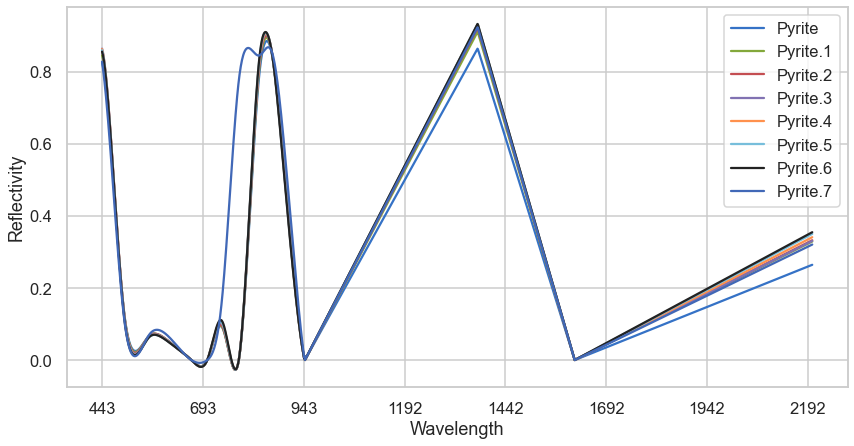

In [16]:
alunites=data[data.base_mineral=='Pyrite'].Minerals.unique()
plt.figure(figsize=(14,7))
for i,al in enumerate(alunites):
    data_IDX.loc[al].plot(label=al)
plt.legend()
plt.ylabel('Reflectivity')
plt.xlabel('Wavelength')

In [17]:
X=data.drop(['Minerals','base_mineral','base_mineral_group'],axis=1)
y=data.base_mineral_group

In [18]:
## Traditional PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
lowDim_mins = pd.DataFrame(pca.fit_transform(X), index=data.Minerals,columns=['X','Y'])
lowDim_mins.reset_index(inplace=True)

Let's run t-sne on the USGS_Mineral dataset

In [19]:
Y = tsne(X,initial_dims=1000,perplexity=perp,max_iter=1000)

Preprocessing the data using PCA...
Computing P-values for point 0 of 1873...
Computing P-values for point 500 of 1873...
Computing P-values for point 1000 of 1873...
Computing P-values for point 1500 of 1873...
Mean value of sigma: 3.601334
Iteration 100: error is 15.073208
Iteration 200: error is 0.673272
Iteration 300: error is 0.636843
Iteration 400: error is 0.629085
Iteration 500: error is 0.626000
Iteration 600: error is 0.624476
Iteration 700: error is 0.623638
Iteration 800: error is 0.623128
Iteration 900: error is 0.622453
Iteration 1000: error is 0.621542


Now let's use Matplotlib's scatter() function to plot a scatterplot, using a different color for each mineral_group:

In [20]:
Y2=pd.DataFrame(Y,columns=['X','Y'])
Y2['BM']=data.base_mineral
Y2['BM_g']=data.base_mineral_group

In [21]:
# this is the minerals with the most variations
# k=Y2.BM_g.unique()
# Y2.BM.value_counts().sort_values(ascending=False).head(5).plot.bar()

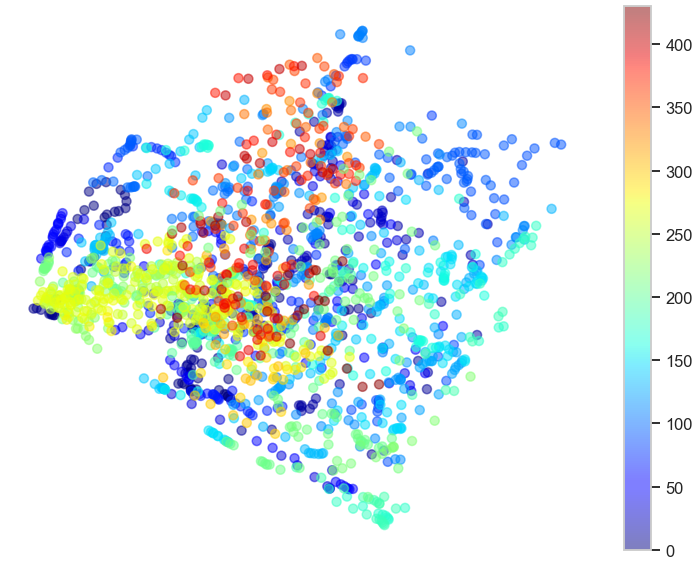

In [22]:
plt.figure(figsize=(13,10))
plt.scatter(lowDim_mins.X, lowDim_mins.Y, c=y,alpha=.5, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

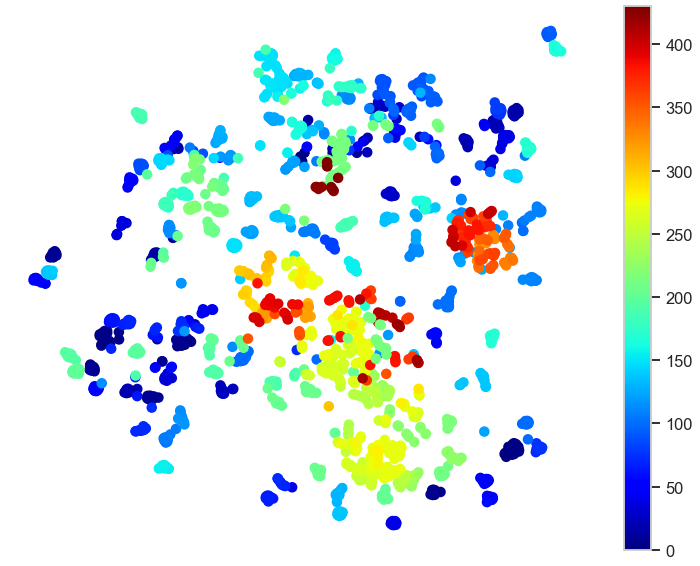

In [23]:
plt.figure(figsize=(13,10))
plt.scatter(Y2.X, Y2.Y, c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

# Lets do it again but for 3 dimensional space

In [24]:
pca = PCA(n_components=3)
lowDim_mins = pd.DataFrame(pca.fit_transform(X), index=data.Minerals,columns=['X','Y','Z'])
lowDim_mins.reset_index(inplace=True)
lowDim_mins

Minerals          X         Y         Z
0                Acmite -10.283087  3.138699  1.571712
1            Actinolite  -9.903453  3.571208  1.599296
2          Actinolite.1  -9.385802  3.791382  1.722942
3          Actinolite.2  -8.782358  3.221495  2.051684
4          Actinolite.3  -8.666745  2.853353  2.184692
...                 ...        ...       ...       ...
1868  WTC_Dust_Debris.1   4.401728  1.070878 -1.294528
1869       Yellow_ochre   1.493052 -2.959447 -2.793480
1870    Ytterbium_Oxide   2.272053 -1.282111 -3.068200
1871      Yttrium_Oxide   3.082684 -0.849036 -2.372488
1872    Yttrium_Oxide.1   3.424828 -0.883729 -2.021197

[1873 rows x 4 columns]

In [25]:
Y = tsne(X,no_dims=3,perplexity=perp,initial_dims=1000,max_iter=1000)

Preprocessing the data using PCA...
Computing P-values for point 0 of 1873...
Computing P-values for point 500 of 1873...
Computing P-values for point 1000 of 1873...
Computing P-values for point 1500 of 1873...
Mean value of sigma: 3.601334
Iteration 100: error is 14.518048
Iteration 200: error is 0.575980
Iteration 300: error is 0.552482
Iteration 400: error is 0.545925
Iteration 500: error is 0.543061
Iteration 600: error is 0.541438
Iteration 700: error is 0.540394
Iteration 800: error is 0.539680
Iteration 900: error is 0.539174
Iteration 1000: error is 0.538801


In [26]:
Y

array([[-41.96459132,  15.18315568, -44.65462218],
       [-42.81695165,  15.44359597, -44.94606492],
       [-43.19600118,  16.26713285, -44.58440827],
       ...,
       [ 13.54444748,  -3.02833805,  30.43804706],
       [ 12.79454003,  -3.3079267 ,  29.36928434],
       [ 12.71399477,  -3.39573105,  29.19976607]])

In [27]:
Y3=pd.DataFrame(Y,columns=['X','Y','Z'])
Y3['BM']=data.base_mineral
Y3['BM_g']=data.base_mineral_group

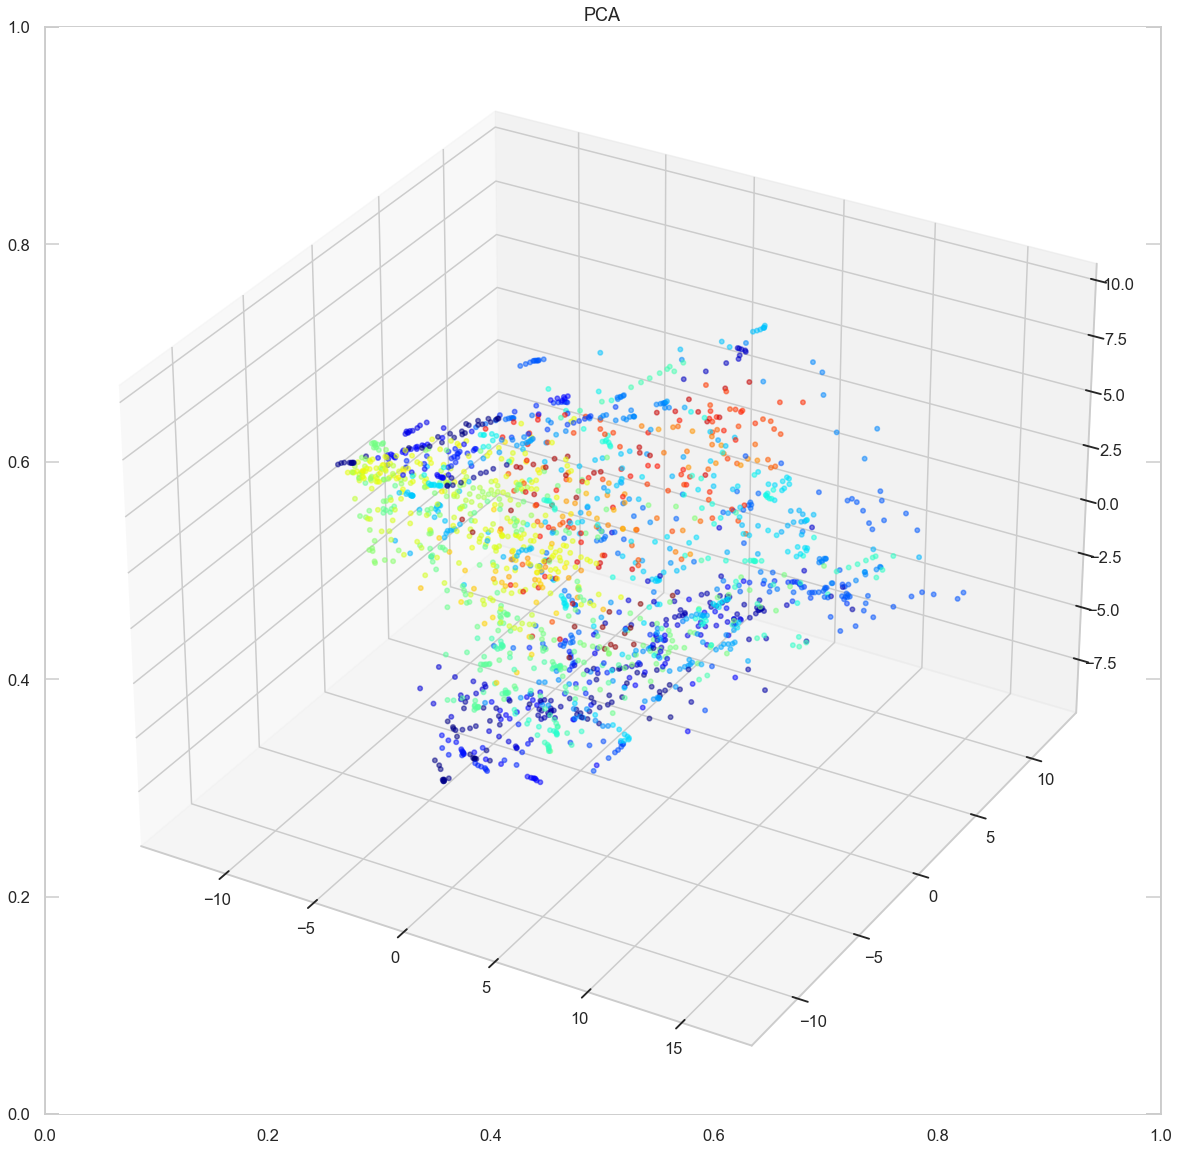

In [28]:
plt.figure(figsize=figsizes)
plt.title('PCA')
#create 3D AXRS
ax=plt.axes(projection='3d')
ax.scatter (lowDim_mins.X,
            lowDim_mins.Y,
            lowDim_mins.Z,alpha=.5, c=y, cmap="jet")
#plt.axis('off')
plt.show()

In [29]:
# scroll to to the bottom of this notebook for an interactve version!!  %matplotlib notebook

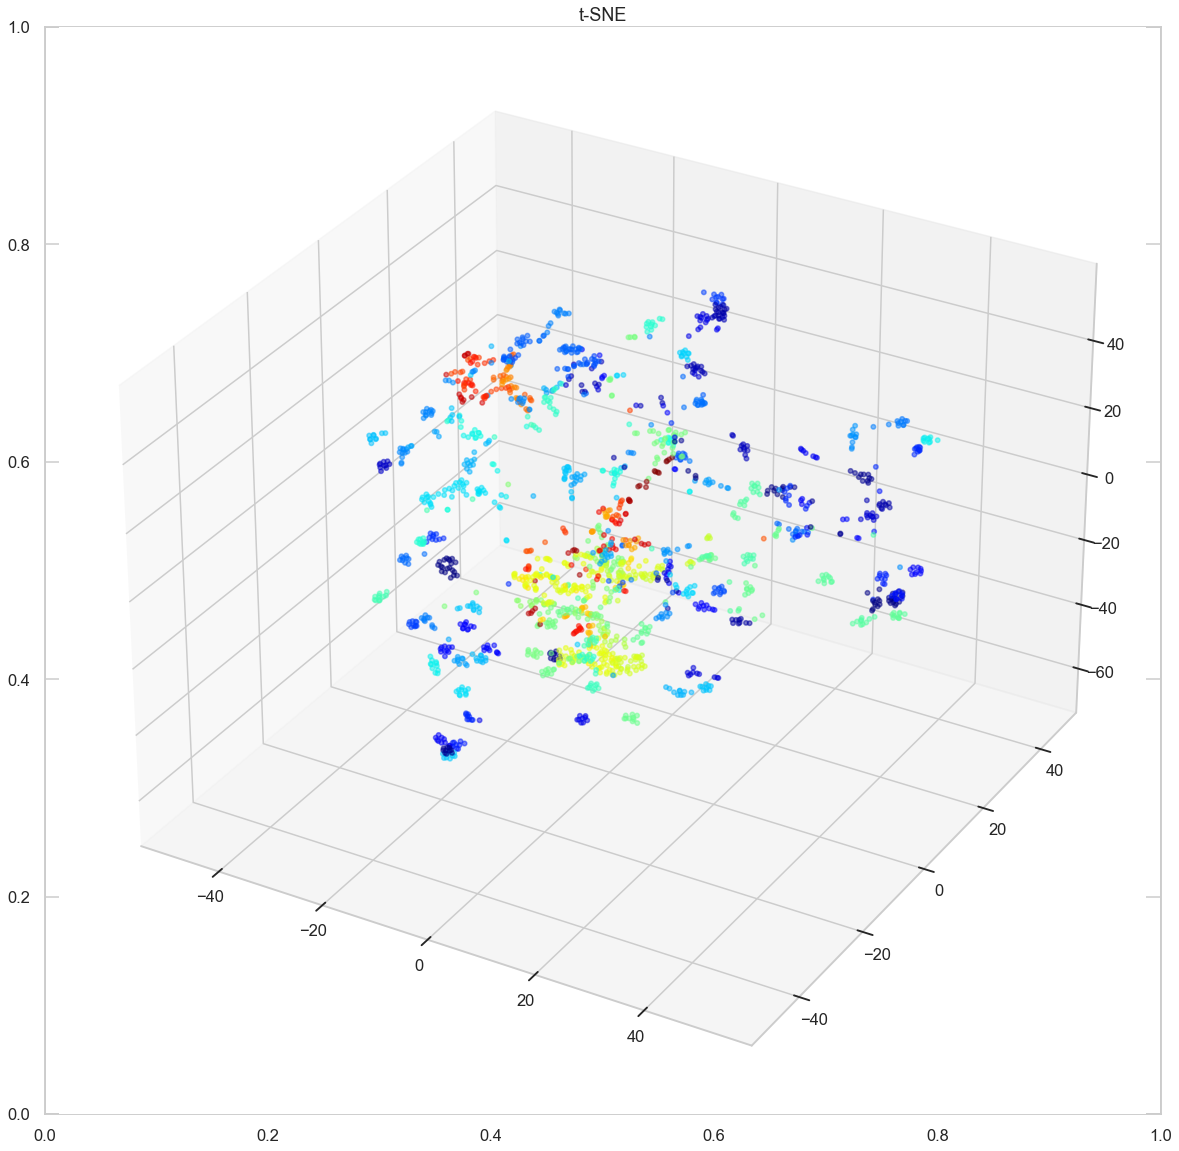

In [30]:

plt.figure(figsize=figsizes)
plt.title('t-SNE')
#create 3D AXRS
ax=plt.axes(projection='3d')
ax.scatter (Y3.X,
            Y3.Y,
            Y3.Z, c=y,alpha=.5, cmap="jet")
#plt.axis('off')
plt.show()

# Time to classify new data!
## This is the Map life spectral data set created from a hand held data spectra measurement device.

In [31]:
mplf_reflect=pd.read_csv('Map.Life_Handheld_Spectral_Test_Data_-_Reflectance.csv')
mplf_reflect.head(1)


id       x        y      z          hyperspecdid       350       351  \
0  B305851  747614  3725024  382.9  TU20153303S00001.asd  0.323052  0.319589   

        352       353       354  ...      2491      2492      2493    2494  \
0  0.317523  0.317978  0.318037  ...  0.540721  0.540176  0.539584  0.5394   

       2495      2496      2497      2498      2499      2500  
0  0.539791  0.540127  0.540228  0.540361  0.540207  0.540048  

[1 rows x 2156 columns]

In [32]:
# FIX DIMENSIONS to match USGS spectra By selecting all rows from 443 wave length onwards to 2204

S = 98
N = 1860
reflect_small = mplf_reflect.iloc[: , S:N]
reflect_small.tail()

443       444       445       446       447       448       449  \
28  0.531780  0.530978  0.530272  0.529698  0.529155  0.528532  0.528050   
29  0.581254  0.580494  0.579749  0.579092  0.578535  0.577904  0.577333   
30  0.491716  0.490973  0.490331  0.489757  0.489119  0.488426  0.487834   
31  0.499794  0.498914  0.498269  0.497729  0.496979  0.496421  0.495962   
32  0.712304  0.711401  0.710782  0.710279  0.709496  0.709092  0.708757   

         450       451       452  ...      2195      2196      2197      2198  \
28  0.527673  0.527078  0.526530  ...  0.395924  0.392391  0.388907  0.385507   
29  0.576888  0.576541  0.576199  ...  0.538246  0.534780  0.531299  0.527853   
30  0.487361  0.486871  0.486407  ...  0.366684  0.363613  0.360607  0.357693   
31  0.495507  0.495006  0.494588  ...  0.378192  0.374951  0.371750  0.368674   
32  0.708330  0.707889  0.707472  ...  0.602250  0.598310  0.594388  0.590486   

        2199      2200      2201      2202      2203      2204  
28  0.382164  0.378859  0.375609  0.372452  0.369302  0.366381  
29  0.524427  0.521020  0.517660  0.514349  0.511048  0.507889  
30  0.354838  0.352054  0.349367  0.346724  0.344116  0.341664  
31  0.365638  0.362685  0.359886  0.357110  0.354339  0.351789  
32  0.586591  0.582794  0.579051  0.575363  0.571694  0.568214  

[5 rows x 1762 columns]

In [33]:
reflect_small.isna().sum().sum()

0

Text(0.5, 0, 'Wavelength')

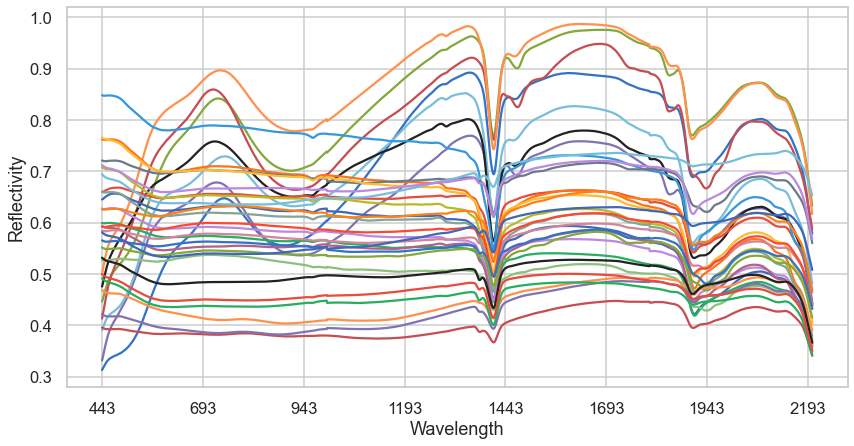

In [34]:
plt.figure(figsize=(14,7))
for i in range(reflect_small.shape[0]):
    reflect_small.iloc[i].plot()
    
plt.ylabel('Reflectivity')
plt.xlabel('Wavelength')

In [35]:
X=data.drop(['Minerals','base_mineral','base_mineral_group'],axis=1)
X

443       444       445       446       447       448       449  \
0     0.034215  0.041745  0.049730  0.058172  0.067049  0.076341  0.086027   
1     0.032977  0.041117  0.049783  0.058974  0.068667  0.078838  0.089463   
2     0.026365  0.035249  0.044702  0.054727  0.065296  0.076383  0.087962   
3     0.023850  0.033116  0.042955  0.053368  0.064329  0.075810  0.087787   
4     0.022148  0.031759  0.041944  0.052704  0.064011  0.075839  0.088161   
...        ...       ...       ...       ...       ...       ...       ...   
1868  0.696847  0.702731  0.708189  0.713219  0.717853  0.722121  0.726053   
1869  0.001025  0.008160  0.015946  0.024387  0.033447  0.043092  0.053290   
1870  0.045459  0.049190  0.053225  0.057575  0.062239  0.067216  0.072510   
1871  0.485001  0.491590  0.497753  0.503491  0.508855  0.513898  0.518665   
1872  0.577516  0.583974  0.589939  0.595412  0.600442  0.605079  0.609369   

           450       451       452  ...      2194      2195      2196  \
0     0.096089  0.106509  0.117267  ...  0.000681  0.000608  0.000536   
1     0.100520  0.111986  0.123843  ...  0.000825  0.000737  0.000649   
2     0.100009  0.112500  0.125413  ...  0.001187  0.001061  0.000934   
3     0.100233  0.113126  0.126441  ...  0.001983  0.001771  0.001560   
4     0.100953  0.114189  0.127848  ...  0.002251  0.002011  0.001771   
...        ...       ...       ...  ...       ...       ...       ...   
1868  0.729677  0.733017  0.736100  ...  0.766125  0.766854  0.767584   
1869  0.064011  0.075225  0.086906  ...  0.765990  0.766685  0.767379   
1870  0.078123  0.084060  0.090325  ...  0.761825  0.762481  0.763136   
1871  0.523203  0.527551  0.531749  ...  0.737663  0.738239  0.738816   
1872  0.613354  0.617076  0.620572  ...  0.732264  0.732807  0.733350   

          2197      2198      2199      2200      2201      2202      2203  
0     0.000463  0.000390  0.000318  0.000245  0.000172  0.000100  0.000027  
1     0.000561  0.000473  0.000385  0.000297  0.000209  0.000121  0.000033  
2     0.000807  0.000681  0.000554  0.000427  0.000301  0.000174  0.000047  
3     0.001348  0.001137  0.000925  0.000714  0.000502  0.000291  0.000079  
4     0.001531  0.001291  0.001051  0.000810  0.000570  0.000330  0.000090  
...        ...       ...       ...       ...       ...       ...       ...  
1868  0.768314  0.769044  0.769774  0.770504  0.771234  0.771963  0.772693  
1869  0.768073  0.768767  0.769461  0.770155  0.770850  0.771544  0.772238  
1870  0.763792  0.764447  0.765103  0.765758  0.766414  0.767069  0.767725  
1871  0.739392  0.739969  0.740545  0.741122  0.741699  0.742275  0.742852  
1872  0.733893  0.734436  0.734980  0.735523  0.736066  0.736609  0.737152  

[1873 rows x 1762 columns]

In [36]:
reflect_small.columns

Index(['443', '444', '445', '446', '447', '448', '449', '450', '451', '452',
       ...
       '2195', '2196', '2197', '2198', '2199', '2200', '2201', '2202', '2203',
       '2204'],
      dtype='object', length=1762)

In [37]:
X.columns

Index(['443', '444', '445', '446', '447', '448', '449', '450', '451', '452',
       ...
       '2194', '2195', '2196', '2197', '2198', '2199', '2200', '2201', '2202',
       '2203'],
      dtype='object', length=1762)

In [38]:
X.isna().sum().sum()

0

In [39]:
pca = PCA(n_components=2)
lowDim_mins = pd.DataFrame(pca.fit_transform(X), index=data.Minerals,columns=['X','Y'])
lowDim_mins.reset_index(inplace=True)
lowDim_mins

Minerals          X         Y
0                Acmite -10.283087  3.138699
1            Actinolite  -9.903453  3.571208
2          Actinolite.1  -9.385802  3.791382
3          Actinolite.2  -8.782358  3.221495
4          Actinolite.3  -8.666745  2.853353
...                 ...        ...       ...
1868  WTC_Dust_Debris.1   4.401728  1.070878
1869       Yellow_ochre   1.493052 -2.959447
1870    Ytterbium_Oxide   2.272053 -1.282111
1871      Yttrium_Oxide   3.082684 -0.849036
1872    Yttrium_Oxide.1   3.424828 -0.883729

[1873 rows x 3 columns]

In [40]:
Y= tsne(X,no_dims=2, perplexity=perp,initial_dims=1000,max_iter=1000)
Y2_big=pd.DataFrame(Y,columns=['X','Y'])

Preprocessing the data using PCA...
Computing P-values for point 0 of 1873...
Computing P-values for point 500 of 1873...
Computing P-values for point 1000 of 1873...
Computing P-values for point 1500 of 1873...
Mean value of sigma: 3.601334
Iteration 100: error is 14.915161
Iteration 200: error is 0.661387
Iteration 300: error is 0.626510
Iteration 400: error is 0.618692
Iteration 500: error is 0.615847
Iteration 600: error is 0.614428
Iteration 700: error is 0.613003
Iteration 800: error is 0.612503
Iteration 900: error is 0.611939
Iteration 1000: error is 0.611297


In [41]:
Y2=Y2_big.drop(Y2_big.tail(33).index)
Y2_unk=Y2_big.tail(33).copy()
Y2['BM']=data.base_mineral
Y2['BM_g']=data.base_mineral_group
Y2_unk['id']=mplf_reflect.id.copy()

lowDim_mins_unk=lowDim_mins.tail(33).copy()
lowDim_mins=lowDim_mins.drop(lowDim_mins.tail(33).index)
lowDim_mins['BM']=data.base_mineral
lowDim_mins['BM_g']=data.base_mineral_group
lowDim_mins_unk['id']=mplf_reflect.id.copy()

## Quickly make some custom markers for vissualization

In [51]:
markers = [
    'o',
    'v',
    '^',
    '<',
    '>',
    '8',
    's',
    'p',
    'P',
    '*',
    'h',
    'H',
    '+',
    'x',
    'D',
    'd']  
fillstyles = ['full', 'bottom', 'top', 'none']
colors=['b','r','g','c','m','y','k','w']
#colors=[‘b’,‘r’,3,4,5,6,7,8,9,10]

marker_combos=[markers,fillstyles,colors]
from itertools import product
import random
marker_styles = [[M,L,C] for M,L,C in product(marker_combos[0],marker_combos[1],marker_combos[2])]
# random.shuffle(marker_styles)
markersdf=pd.DataFrame(marker_styles,columns=['m','f','c'])

from matplotlib.markers import MarkerStyle

markermap= { i : marker for i, marker in enumerate(markersdf['m']) }
fillmap= { i : marker for i,marker in enumerate(markersdf['f']) }
colormap= { i : marker for i,marker in enumerate(markersdf['c']) }

Y2['m']=Y2.BM_g.map(markermap)
Y2['f']=Y2.BM_g.map(fillmap)
Y2['c']=Y2.BM_g.map(colormap)

lowDim_mins['m']=lowDim_mins.BM_g.map(markermap)
lowDim_mins['f']=lowDim_mins.BM_g.map(fillmap)
lowDim_mins['c']=lowDim_mins.BM_g.map(colormap)

unk_linewidths=.5
unk_edgecolor='black'
unk_size=450
unk_color='fuchsia'
unk_marker='*'


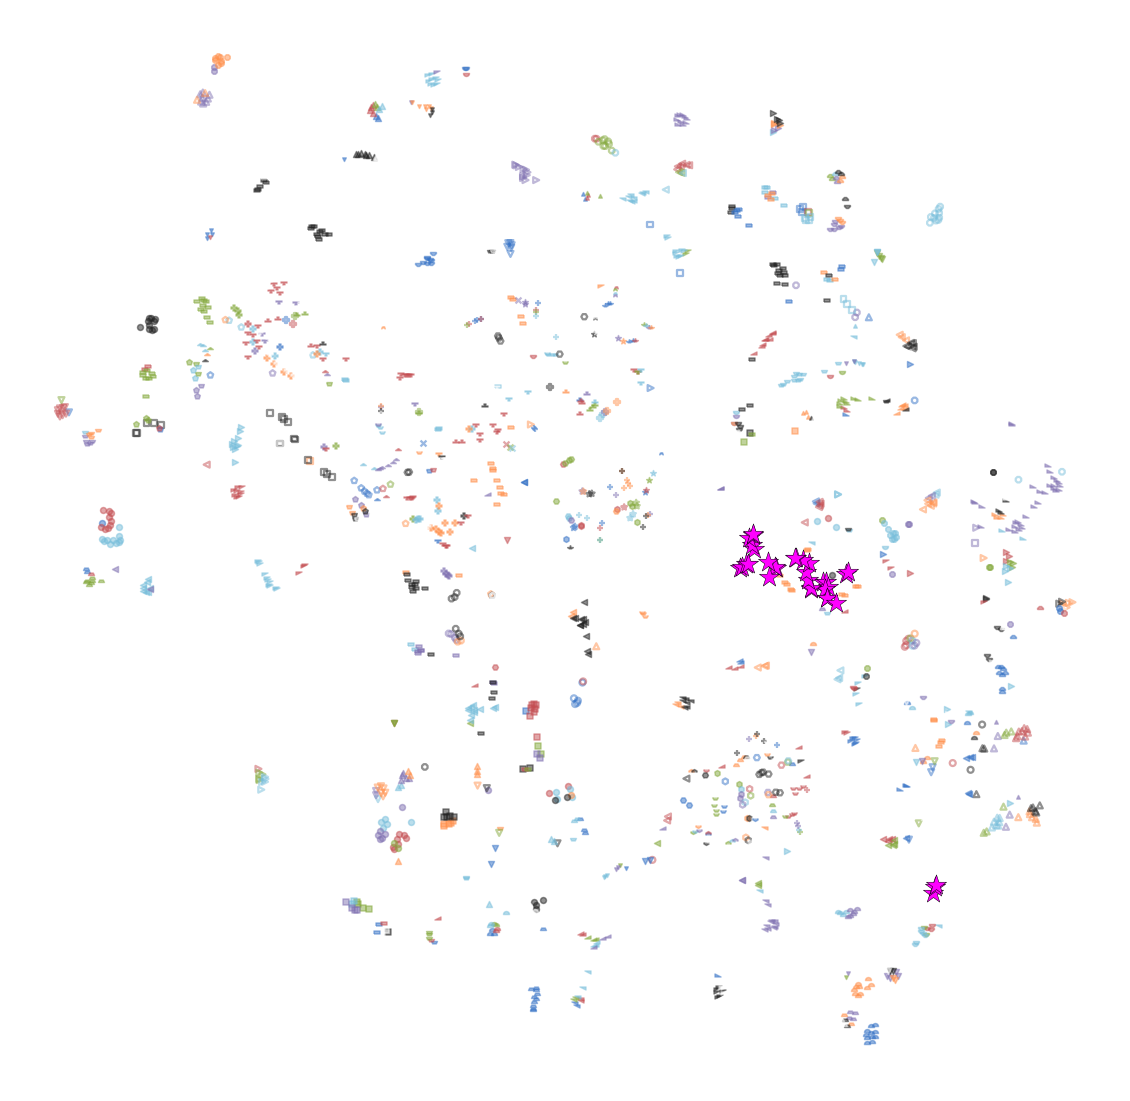

In [52]:
k=Y2.BM_g.unique()
minerals=Y2.BM.unique()
plt.figure(figsize=figsizes)
for i in k:
    m=Y2.m[Y2.BM_g==i].unique()[0]
    f=Y2.f[Y2.BM_g==i].unique()[0]
    c=Y2.c[Y2.BM_g==i].unique()[0]
    plt.scatter( 
        Y2.X[Y2.BM_g==i], 
        Y2.Y[Y2.BM_g==i], 
        marker=MarkerStyle(marker=m, fillstyle=f),
        color=c,
        s=35,
        alpha=.5,
        label=minerals[i]
    )
plt.scatter(Y2_unk.X, Y2_unk.Y,s=unk_size,marker=unk_marker,edgecolor=unk_edgecolor,linewidths=unk_linewidths,color=unk_color,label='unknown minerals')
plt.axis('off')
#plt.legend(loc="lower center",ncol=13, bbox_to_anchor=(-1.25, 0.5))
plt.show()

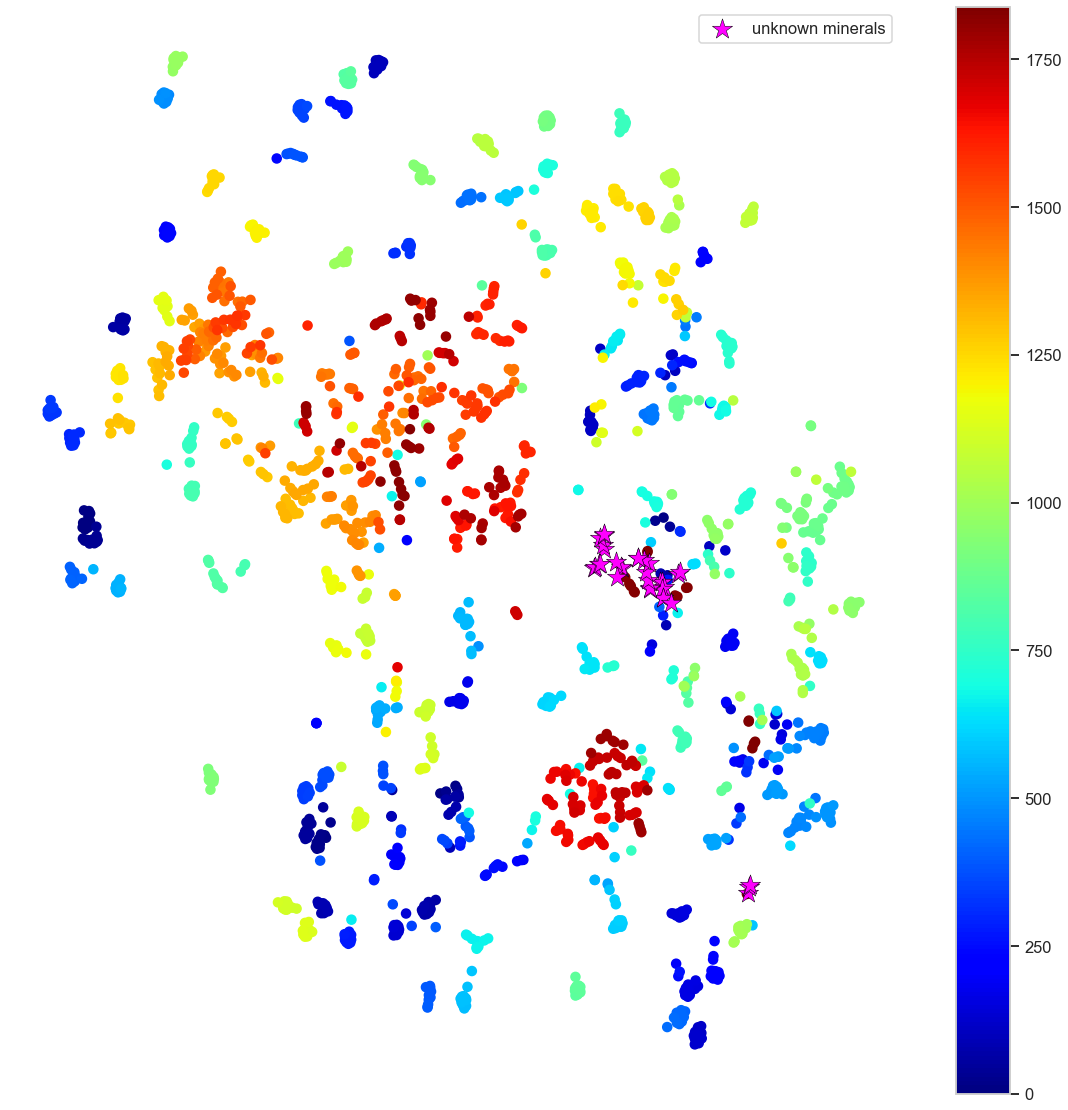

In [53]:
plt.figure(figsize=figsizes)
plt.scatter(Y2.X, Y2.Y, c=Y2.index, cmap="jet")
plt.colorbar()
plt.scatter(Y2_unk.X, Y2_unk.Y,s=unk_size,marker=unk_marker,edgecolor=unk_edgecolor,linewidths=unk_linewidths,color=unk_color,label='unknown minerals')
plt.legend()
plt.axis('off')
plt.show()

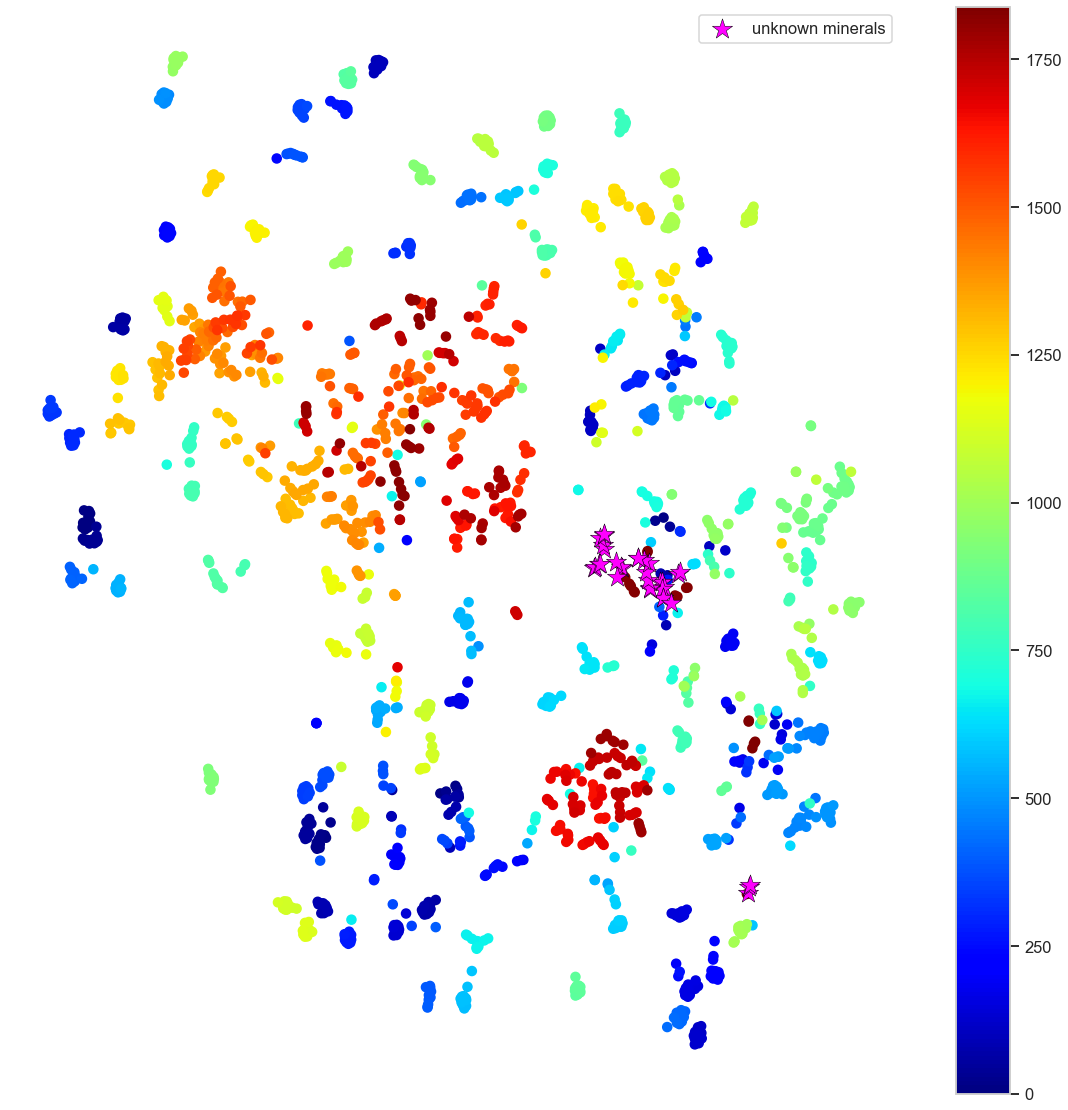

In [54]:
plt.figure(figsize=figsizes)
plt.scatter(Y2.X, Y2.Y, c=Y2.index, cmap="jet")
plt.colorbar()
plt.scatter(Y2_unk.X, Y2_unk.Y,s=unk_size,marker=unk_marker,edgecolor=unk_edgecolor,linewidths=unk_linewidths,color=unk_color,label='unknown minerals')
plt.legend()
plt.axis('off')
plt.show()

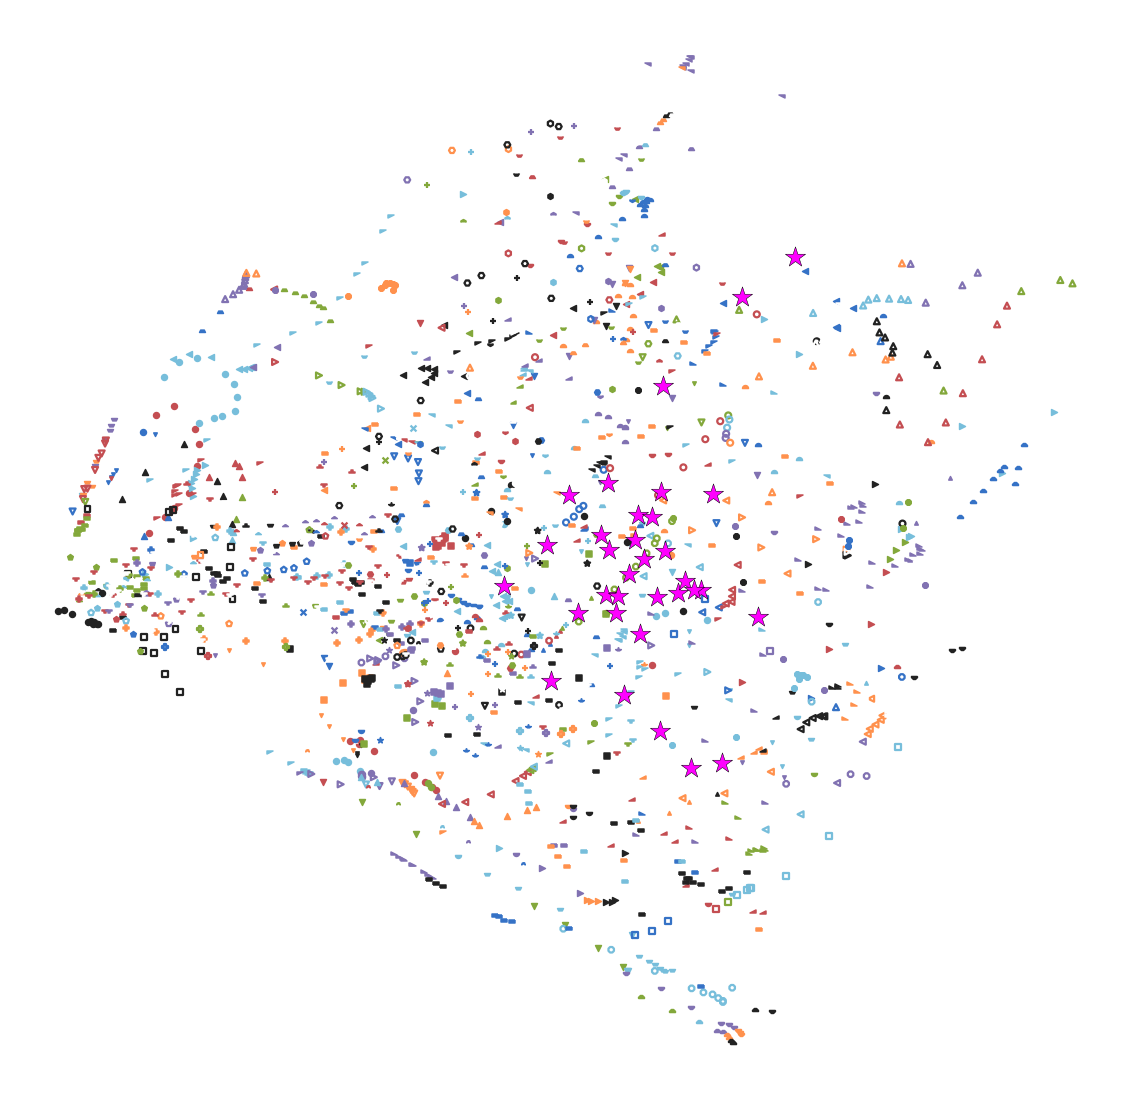

In [55]:
k=Y2.BM_g.unique()
minerals=Y2.BM.unique()
plt.figure(figsize=figsizes)
for i in k:
    m=lowDim_mins.m[lowDim_mins.BM_g==i].unique()[0]
    f=lowDim_mins.f[lowDim_mins.BM_g==i].unique()[0]
    c=lowDim_mins.c[lowDim_mins.BM_g==i].unique()[0]
    plt.scatter( 
        lowDim_mins.X[lowDim_mins.BM_g==i], 
        lowDim_mins.Y[lowDim_mins.BM_g==i], 
        marker=MarkerStyle(marker=m, fillstyle=f),
        color=c,
        s=35,
        label=minerals[i]
    )

plt.scatter(lowDim_mins_unk.X, lowDim_mins_unk.Y,s=unk_size,marker=unk_marker,edgecolor=unk_edgecolor,linewidths=unk_linewidths,color=unk_color,label='unknown minerals')
plt.axis('off')
#plt.legend(loc="lower center",ncol=13, bbox_to_anchor=(-1.25, 0.5))
plt.show()

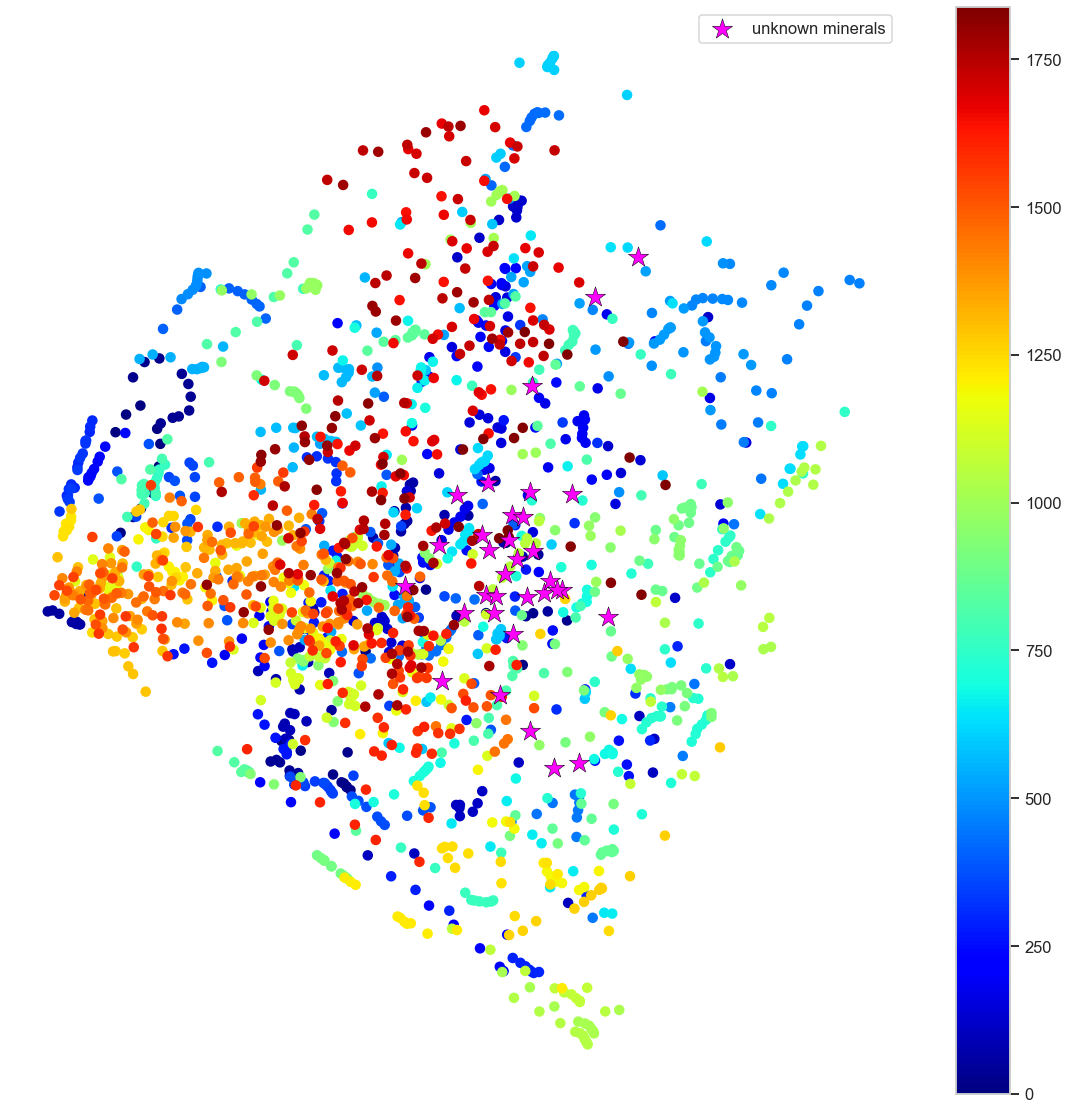

In [56]:
plt.figure(figsize=figsizes)
plt.scatter(lowDim_mins.X, lowDim_mins.Y, c=lowDim_mins.index, cmap="jet")
plt.colorbar()
plt.scatter(lowDim_mins_unk.X, lowDim_mins_unk.Y,s=unk_size,marker=unk_marker,edgecolor=unk_edgecolor,linewidths=unk_linewidths,color=unk_color,label='unknown minerals')
plt.axis('off')
plt.legend()
plt.show()

 ## Lets Do it again but with 3 dimensions again!

In [57]:
pca = PCA(n_components=3)
lowDim_mins = pd.DataFrame(pca.fit_transform(X), index=data.Minerals,columns=['X','Y','Z'])
lowDim_mins.reset_index(inplace=True)

lowDim_mins_unk=lowDim_mins.tail(33).copy()
lowDim_mins=lowDim_mins.drop(lowDim_mins.tail(33).index)
lowDim_mins['BM']=data.base_mineral
lowDim_mins['BM_g']=data.base_mineral_group
lowDim_mins_unk['id']=mplf_reflect.id.copy()

lowDim_mins['m']=lowDim_mins.BM_g.map(markermap)
lowDim_mins['f']=lowDim_mins.BM_g.map(fillmap)
lowDim_mins['c']=lowDim_mins.BM_g.map(colormap)

In [58]:
Y= tsne(X,no_dims=3,perplexity=perp,initial_dims=1000,max_iter=1000)
Y3_big=pd.DataFrame(Y,columns=['X','Y','Z'])

Preprocessing the data using PCA...
Computing P-values for point 0 of 1873...
Computing P-values for point 500 of 1873...
Computing P-values for point 1000 of 1873...
Computing P-values for point 1500 of 1873...
Mean value of sigma: 3.601334
Iteration 100: error is 14.515405
Iteration 200: error is 0.577376
Iteration 300: error is 0.552254
Iteration 400: error is 0.545480
Iteration 500: error is 0.542470
Iteration 600: error is 0.540767
Iteration 700: error is 0.539686
Iteration 800: error is 0.538940
Iteration 900: error is 0.538408
Iteration 1000: error is 0.538008


In [59]:
Y3=Y3_big.drop(Y3_big.tail(33).index)
Y3_unk=Y3_big.tail(33).copy()
Y3['BM']=data.base_mineral
Y3['BM_g']=data.base_mineral_group
Y3_unk['id']=mplf_reflect.id.copy()
Y3['m']=Y3.BM_g.map(markermap)
Y3['f']=Y3.BM_g.map(fillmap)
Y3['c']=Y3.BM_g.map(colormap)


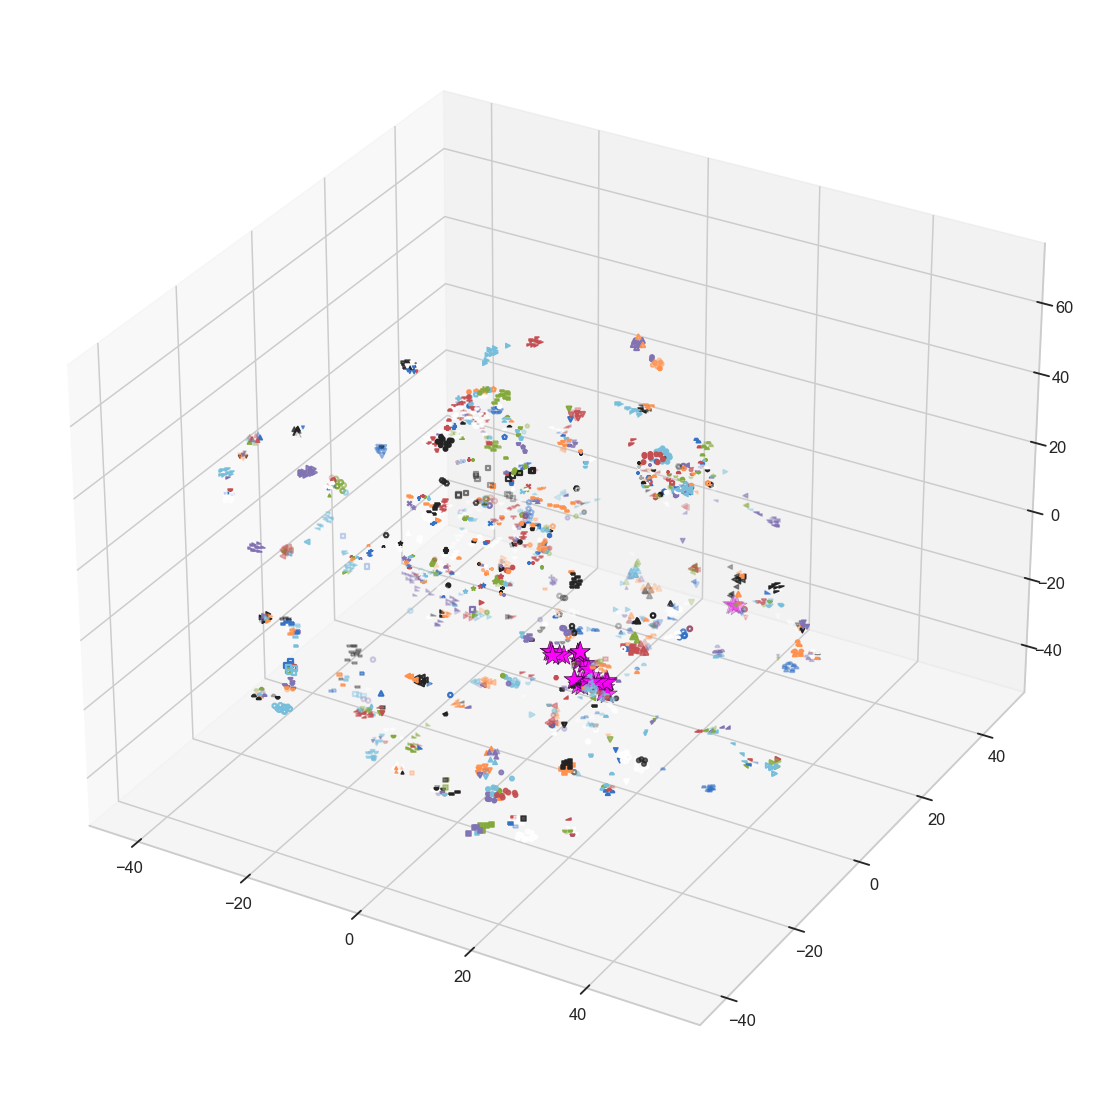

In [60]:

plt.figure(figsize=figsizes)
#create 3D AXRS
ax=plt.axes(projection='3d')



for i in k:
    m=Y3.m[Y2.BM_g==i].unique()[0]
    f=Y3.f[Y2.BM_g==i].unique()[0]
    c=Y3.c[Y2.BM_g==i].unique()[0]
    ax.scatter (Y3.X[Y3.BM_g==i],
                Y3.Y[Y3.BM_g==i],
                Y3.Z[Y3.BM_g==i],
                marker=MarkerStyle(marker=m, fillstyle=f),
                color=c,
                label=minerals[i])
ax.scatter (Y3_unk.X,
            Y3_unk.Y,
            Y3_unk.Z, 
            s=unk_size,
            marker=unk_marker,
            edgecolor=unk_edgecolor,
            linewidths=unk_linewidths,
            color=unk_color,
            label='unknown minerals')
plt.show()

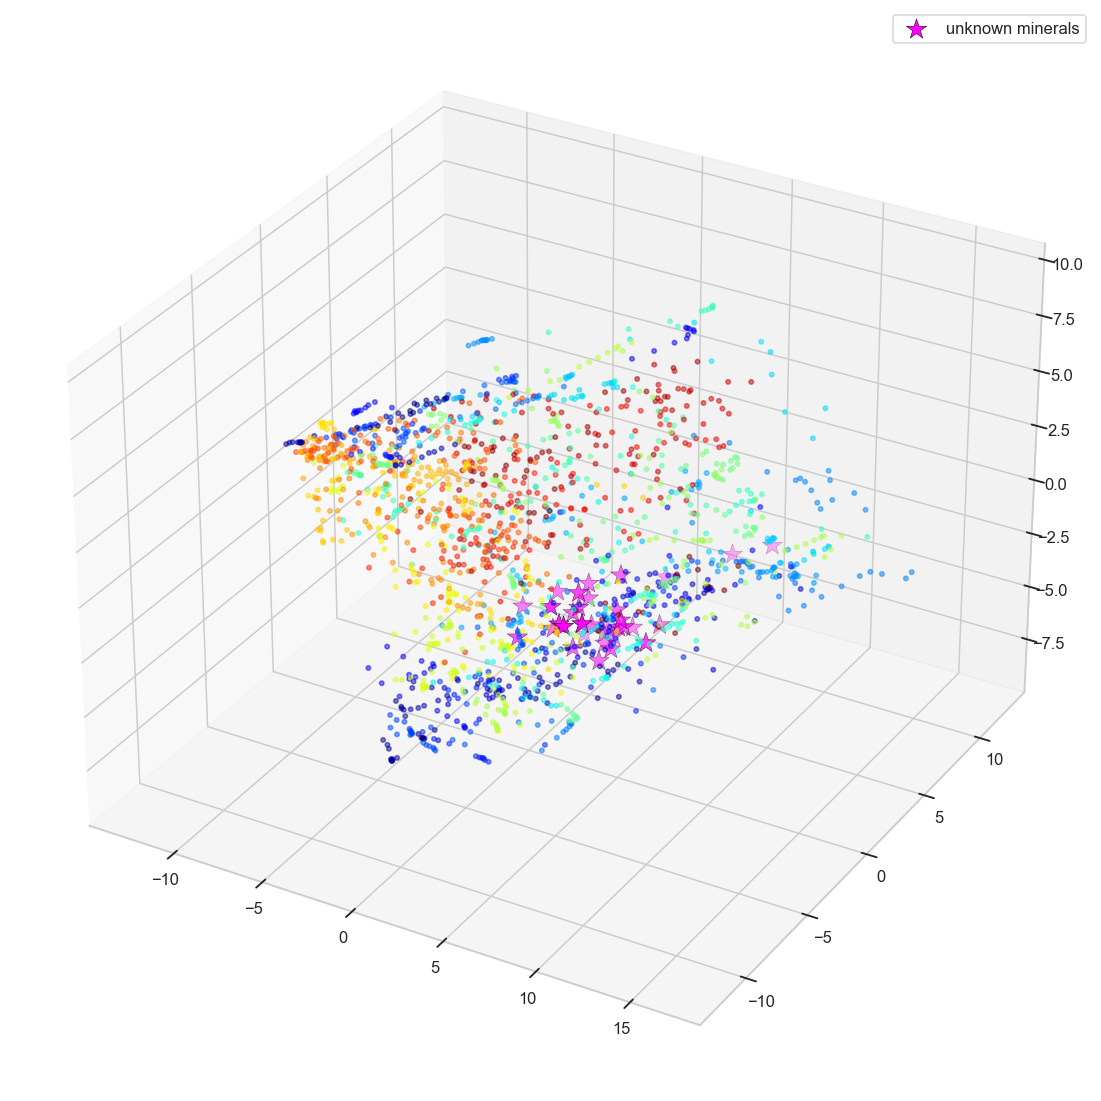

In [67]:

plt.figure(figsize=figsizes)
#create 3D AXRS
ax=plt.axes(projection='3d')

ax.scatter (lowDim_mins.X,
            lowDim_mins.Y,
            lowDim_mins.Z,
            c=lowDim_mins.index,alpha=.5, cmap="jet")

ax.scatter (lowDim_mins_unk.X,
            lowDim_mins_unk.Y,
            lowDim_mins_unk.Z, 
            s=unk_size,
            marker=unk_marker,
            edgecolor=unk_edgecolor,
            linewidths=unk_linewidths,
            color=unk_color,
            label='unknown minerals')
plt.legend()

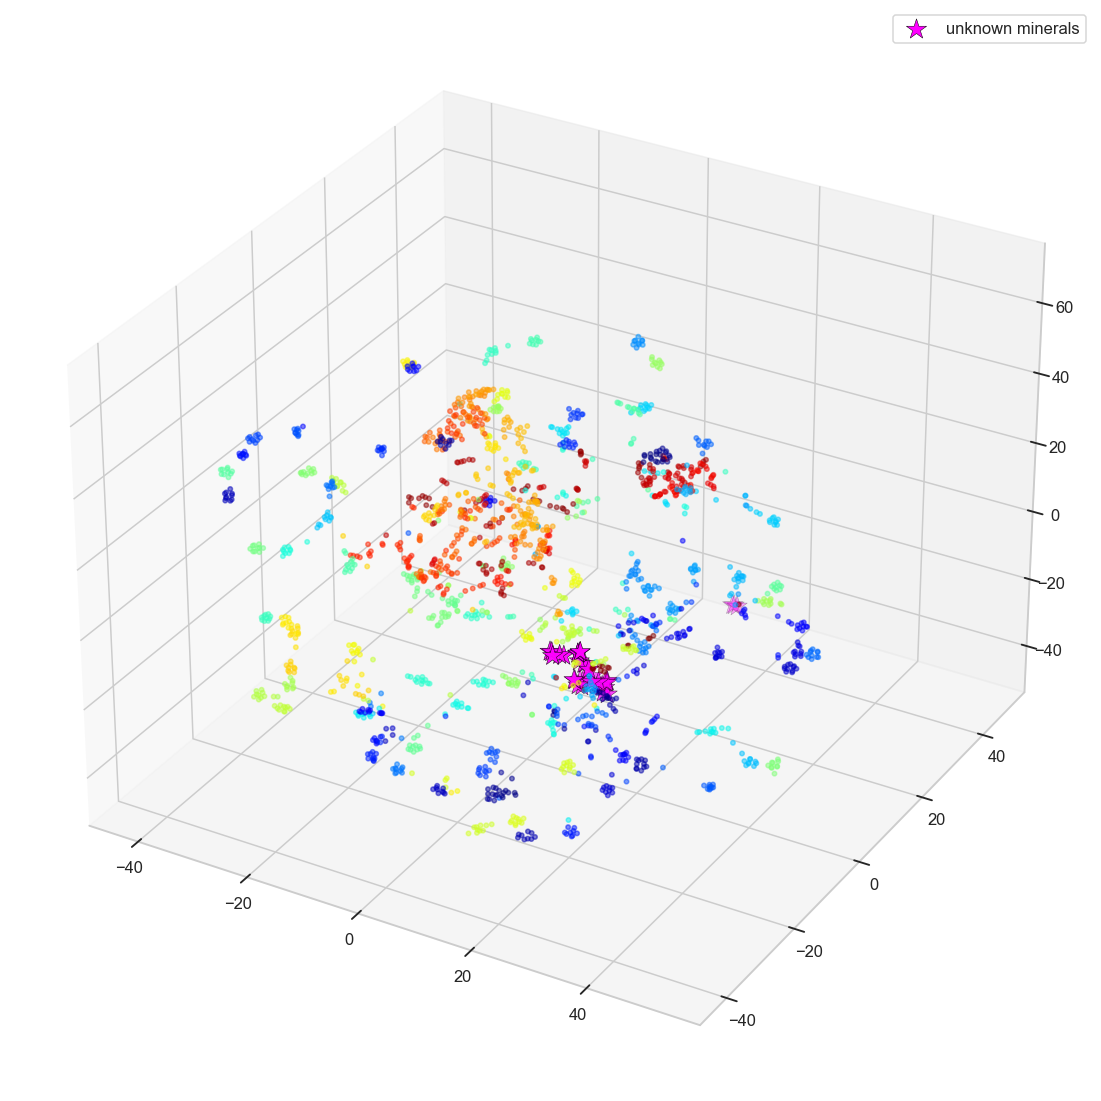

In [66]:
#%matplotlib notebook


plt.figure(figsize=figsizes)
#create 3D AXRS
ax=plt.axes(projection='3d')

ax.scatter (Y3.X,
            Y3.Y,
            Y3.Z,
            c=lowDim_mins.index,alpha=.5, cmap="jet")

ax.scatter (Y3_unk.X,
            Y3_unk.Y,
            Y3_unk.Z, 
            s=unk_size,
            marker=unk_marker,
            edgecolor=unk_edgecolor,
            linewidths=unk_linewidths,
            color=unk_color,
            label='unknown minerals')
plt.legend()
plt.show()

In [ ]:

plt.figure(figsize=figsizes)
plt.title('t-SNE')
#create 3D AXRS
ax=plt.axes(projection='3d')
ax.scatter (Y3.X,
            Y3.Y,
            Y3.Z, c=y,alpha=.5, cmap="jet")
#plt.axis('off')
plt.show()

In [ ]:

plt.figure(figsize=figsizes)
#create 3D AXRS
ax=plt.axes(projection='3d')

ax.scatter (lowDim_mins_unk.X,
            lowDim_mins_unk.Y,
            lowDim_mins_unk.Z, 
            s=unk_size,
            marker=unk_marker,
            edgecolor=unk_edgecolor,
            linewidths=unk_linewidths,
            color=unk_color,
            label='unknown minerals')
plt.show()

In [ ]:
mins=data[['Minerals','base_mineral','base_mineral_group']]

In [ ]:
mins[mins.base_mineral=='Pyrite'
     
    ]